## Setup
Install required python libraries for the workshop


In [23]:
!pip install -U psycopg2-binary pgvector tqdm boto3 requests scikit-image redis

### Downloading Zalando Research data

The dataset itself consists of 8,732 high-resolution images, each depicting a dress from the available on the Zalando shop against a white-background. Each of the images has five textual annotations orinally in German and are translated to english, each of which has been generated by a separate user. 

**Downloading Zalando Research data**: Data originally from here: https://github.com/zalandoresearch/feidegger 

 **Citation:** <br>
 https://github.com/zalandoresearch/feidegger <br>
 *@inproceedings{lefakis2018feidegger,* <br>
 *title={FEIDEGGER: A Multi-modal Corpus of Fashion Images and Descriptions in German},* <br>
 *author={Lefakis, Leonidas and Akbik, Alan and Vollgraf, Roland},* <br>
 *booktitle = {{LREC} 2018, 11th Language Resources and Evaluation Conference},* <br>
 *year      = {2018}* <br>
 *}*

In [24]:
import urllib.request
import os
import json
import boto3
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map

filename = 'metadata.json'

def download_metadata(url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

## The German text has been translated into English and the resulting translation has been stored in this repository for convenience.
download_metadata('https://raw.githubusercontent.com/aws-samples/rds-postgresql-pgvector/master/data/FEIDEGGER_release_1.2.json')

with open(filename) as json_file:
    results = json.load(json_file)

results[0]

{'url': 'https://img01.ztat.net/article/spp-media-p1/3c8812d8b6233a55a5da06b19d780302/dc58460c157b426b817f13e7a2f087c5.jpg?imwidth=400&filter=packshot',
 'descriptions': ['short, sexy, summer, sexy, party, yellow dress, and sleeveless',
  'A yellow dress which is up to about above the knee and has a V-neckline. The dress has a strapless accent',
  'Knee-length fabric dress in yellow with wide skirt, off-the-shoulder with a deep round neckline.',
  'Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than at the front.',
  'Airy summer dress that is slightly longer at the back. It is sleeveless, has a v-neck and wide straps.'],
 'split': '7'}

## Bedrock Embedding

In [25]:
import os
AWS_REGION = 'us-east-1'

# access as a IAM user
os.environ['AWS_DEFAULT_REGION']=AWS_REGION
os.environ['AWS_ACCESS_KEY_ID']='' #TODO
os.environ['AWS_SECRET_ACCESS_KEY']='' #TODO

In [26]:
from langchain.embeddings import BedrockEmbeddings
import boto3

def init_eb_bedrock():
    bedrock_client = boto3.client('bedrock-runtime',
                                region_name=AWS_REGION,
                                aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
                                aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY'])


    modelId = "amazon.titan-embed-text-v1"
    bedrock_embeddings = BedrockEmbeddings(
        client=bedrock_client,
        region_name=AWS_REGION,
        model_id=modelId, 
    )

    return bedrock_embeddings

bedrock_embeddings = init_eb_bedrock()

In [27]:
# Please re-run the cell if it fails.
# Perform a job using realtime inference to generate embeddings ~30 min.

def generate_embeddings(data):
    r = {}
    r['url'] = data['url']
    r['descriptions'] = data['descriptions']
    r['split'] = data['split']
    query = ' '.join(data['descriptions'])
    vector = bedrock_embeddings.embed_query(query)
    r['descriptions_embeddings'] = vector
    return r
    
workers = 1 * cpu_count()

chunksize = 32

#Generate Embeddings
data = process_map(generate_embeddings, results, max_workers=workers, chunksize=chunksize)


  0%|          | 0/8792 [00:00<?, ?it/s]

In [28]:
len(data[0].get('descriptions_embeddings'))

1536

## Open-source extension pgvector in PostgreSQL

pgvector is an open-source extension for PostgreSQL that allows you to store and search vector embeddings for exact and approximate nearest neighbors. It is designed to work seamlessly with other PostgreSQL features, including indexing and querying.

One of the key benefits of using pgvector is that it allows you to perform similarity searches on large datasets quickly and efficiently. This is particularly useful in industries like e-commerce, where businesses need to be able to quickly search through large product catalogs to find the items that best match a customer's preferences. It supports exact and approximate nearest neighbor search, L2 distance, inner product, and cosine distance.

To further optimize your searches, you can also use pgvector's indexing features. By creating indexes on your vector data, you can speed up your searches and reduce the amount of time it takes to find the nearest neighbors to a given vector.

In this step we'll get all the translated product descriptions of *__zalandoresearch__* dataset and store those embeddings into PostgreSQL vector type.

In [29]:
import psycopg2
from pgvector.psycopg2 import register_vector
import boto3 
import json 

def store_vector():
    dbhost = ""
    dbport = "5432"
    dbuser = ""
    dbpass = ""
    name = ""

    dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, dbname = name, connect_timeout=10)
    dbconn.set_session(autocommit=True)

    cur = dbconn.cursor()
    cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
    register_vector(dbconn)
    cur.execute("DROP TABLE IF EXISTS products;")
    cur.execute("""CREATE TABLE IF NOT EXISTS products(
                   id bigserial primary key, 
                   description text, 
                   url text, 
                   split int, 
                   descriptions_embeddings vector(1536));""")

    for x in data:
        description = ' '.join(x.get('descriptions', []))
        url = x.get('url')
        split = x.get('split')
        descriptions_embeddings = x.get('descriptions_embeddings')
        cur.execute("""INSERT INTO products
                          (description, url, split, descriptions_embeddings) 
                      VALUES(%s, %s, %s, %s);""", 
                      (description, url, split, descriptions_embeddings ))

    cur.execute("""CREATE INDEX ON products 
                   USING hnsw (descriptions_embeddings vector_l2_ops) WITH (m = 16, ef_construction = 200);""")
    cur.execute("VACUUM ANALYZE products;")
    cur.execute("SELECT COUNT(*) FROM products;")
    print(list(cur))

    cur.close()
    dbconn.close()
    print ("Vector embeddings has been successfully loaded into PostgreSQL")

In [30]:
import time
start_time = time.time()
store_vector()
print("--- %s seconds ---" % (time.time() - start_time))

[(8792,)]
Vector embeddings has been successfully loaded into PostgreSQL
--- 58.896068811416626 seconds ---


## Evaluate PostgreSQL vector Search Results

In this step we will use SageMaker realtime inference to generate embeddings for the query and use the embeddings to search the PostgreSQL to retrive the nearest neighbours and retrive the relevent product images.


In [41]:
import psycopg2
from pgvector.psycopg2 import register_vector
# from psycopg2.extensions import register_adapter, AsIs
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import requests

def test_pgvector(query):
    
    function_start_time = time.time()
    
    res1 = bedrock_embeddings.embed_query(query)

    dbhost = ""
    dbport = "5432"
    dbuser = ""
    dbpass = ""
    name = ""

    dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, dbname = name, connect_timeout=10)
    dbconn.set_session(autocommit=True)

    cur = dbconn.cursor()

    cur.execute("""SELECT id, url, description, descriptions_embeddings 
                FROM products 
                ORDER BY descriptions_embeddings <-> %s limit 2;""", 
                (np.array(res1),))

    r = cur.fetchall()
    
    print("--- %s seconds to perform vector search on Postgres RDS ---" % (time.time() - function_start_time))
    overhead_start_time = time.time()
    
    urls = []
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    for x in r:
        #print (x)
        url = x[1].split('?')[0]
        urldata = requests.get(url).content
        print ("Product Item Id: " + str(x[0]))
        a = io.imread(url)
        plt.imshow(a)
        plt.axis('off')
        plt.show()

    cur.close()
    dbconn.close()
    print("--- %s seconds to perform other auxiliary operations ---" % (time.time() - overhead_start_time))
    
# def addapt_numpy_array(numpy_array):
#     return AsIs(tuple(numpy_array))

# register_adapter(np.ndarray, addapt_numpy_array)

--- 0.11864972114562988 seconds to perform vector search on Postgres RDS ---
Product Item Id: 553


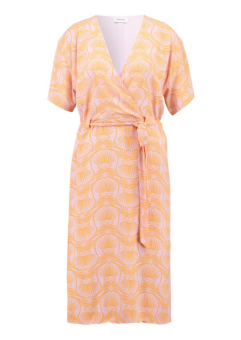

Product Item Id: 7804


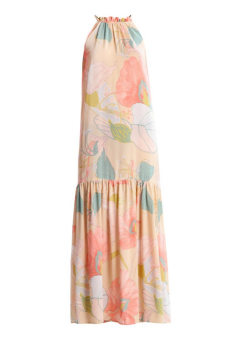

--- 0.6434314250946045 seconds to perform other auxiliary operations ---
--- 0.7642056941986084 seconds to perform the entire function ---


In [69]:
import time
start_time = time.time()
test_pgvector("orange sleeveless summer wear")
print("--- %s seconds to perform the entire function ---" % (time.time() - start_time))

## MemoryDB as vector store
MemoryDB for Redis on AWS has a new feature that supports vector search. This feature is in preview and is subjected to change. 

In [31]:
# Constants
VECTOR_DIM = 1536 # length of the vectors
VECTOR_NUMBER = 8792                # initial number of vectors
INDEX_NAME = "embeddings-index"                 # name of the search index
PREFIX = "doc"                                  # prefix for the document keys
DISTANCE_METRIC = "COSINE"                      # distance metric for the vectors (ex. COSINE, IP, L2)
REDIS_HOST = ""
REDIS_PORT = 6379

In [32]:
import redis

# Check connection
def initialize_redis():
    client = redis.Redis(
        host= REDIS_HOST,
        port= REDIS_PORT, decode_responses=True, ssl=True, ssl_cert_reqs="none")
    try:
        client.ping()
        print("Connection to MemoryDB successful")
        return client
    except Exception as e:
        print("An error occurred while connecting to Redis:", e)
        return None
    
initialize_redis()

Connection to MemoryDB successful


Redis<ConnectionPool<SSLConnection<host=clustercfg.test-vector-v2.czhdpm.memorydb.us-east-1.amazonaws.com,port=6379,db=0>>>

In [282]:
import redis
from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)
from redis.commands.search.field import (
    TextField,
    VectorField
)

# Define RediSearch fields for each of the columns in the dataset
url = TextField(name="url")
descriptions_embeddings = VectorField("descriptions_embeddings",
    "HNSW", {
        "TYPE": "FLOAT32",
        "DIM": VECTOR_DIM,
        "DISTANCE_METRIC": DISTANCE_METRIC,
        "INITIAL_CAP": VECTOR_NUMBER,
    }
)

fields = [url, descriptions_embeddings]

In [34]:
# Check if index exists
client = redis.Redis(
        host=REDIS_HOST, port=REDIS_PORT, decode_responses=True, ssl=True, ssl_cert_reqs="none")
    
try:
    client.ft(INDEX_NAME).info()
    print("Index already exists")
    print(client.ft(INDEX_NAME).dropindex(delete_documents=True))
    # Create RediSearch Index
    print("After deleting original index, create new index")
    print(client.ft(INDEX_NAME).create_index(
        fields = fields,
        definition = IndexDefinition(prefix=[PREFIX], index_type=IndexType.HASH)
    ))
except:
#     Create RediSearch Index
    print("Index does not exist, create new index")
    print(client.ft(INDEX_NAME).create_index(
        fields = fields,
        definition = IndexDefinition(prefix=[PREFIX], index_type=IndexType.HASH)
    ))

In [318]:
import numpy as np
import urllib.parse

def index_documents(client: redis.Redis, prefix: str, records: dict):
    for r in records:
        url = r.get('url').strip()
        key = f"{prefix}:{url}"
        descriptions_embeddings = r.get('descriptions_embeddings')
        embedding = np.array(descriptions_embeddings, dtype=np.float32).tobytes()
        client.hset(key, mapping={'descriptions_embeddings': embedding, 'url': url})

In [286]:
import time
start_time = time.time()
index_documents(client, PREFIX, data)
print("--- %s seconds ---" % (time.time() - start_time))

--- 92.3687059879303 seconds ---
result:  None


In [35]:
# index_documents(redis_client, PREFIX, article_df)
print(f"Loaded {client.info()['db0']['keys']} documents in Redis search index with name: {INDEX_NAME}")

Loaded 8792 documents in Redis search index with name: embeddings-index


In [38]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import requests
from redis.commands.search.query import Query

def search_redis(
    redis_client: redis.Redis,
    user_query: str,
    index_name: str = INDEX_NAME,
    vector_field: str = "descriptions_embeddings",
    return_fields: list = ["url"],
    hybrid_fields = "*",
    k: int = 10,
) -> list[dict]:

    # record the time needed for entire function
    function_start_time = time.time()
    
    # Creates embedding vector from user query
    embedded_query = bedrock_embeddings.embed_query(user_query)

    # Prepare the Query
    base_query = f'{hybrid_fields}=>[KNN {k} @{vector_field} $vector AS vector_score]'
    query = (
        Query(base_query)
         .return_fields(*return_fields)
         .sort_by("vector_score")
         .paging(0, k)
         .dialect(2)
    )
    params_dict = {"vector": np.array(embedded_query).astype(dtype=np.float32).tobytes()}
    
    # perform vector search
    results = redis_client.ft(index_name).search(query, params_dict)
    print("--- %s seconds to perform vector search on memoryDB ---" % (time.time() - function_start_time))
    overhead_start_time = time.time()
    
    dbhost = ""
    dbport = "5432"
    dbuser = ""
    dbpass = ""
    name = ""

    dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, dbname = name, connect_timeout=10)
    dbconn.set_session(autocommit=True)

    cur = dbconn.cursor()
    
    for i, article in enumerate(results.docs):
        url = article.url
        url_tocall = url.split('?')[0]
        urldata = requests.get(url_tocall).content
        
        # query RDS for product ID
        query_rds = f"SELECT id FROM products WHERE url = \'{url}\';"
        
        cur.execute(query_rds)
        _id = list(cur)
        
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True
        
        print ("Product Item Id: " + str(_id[0][0]))
        a = io.imread(url)
        plt.imshow(a)
        plt.axis('off')
        plt.show()

    cur.close()
    dbconn.close()
    print("--- %s seconds to perform other auxiliary operations ---" % (time.time() - overhead_start_time))

--- 0.10746884346008301 seconds to perform vector search on memoryDB ---
Product Item Id: 553


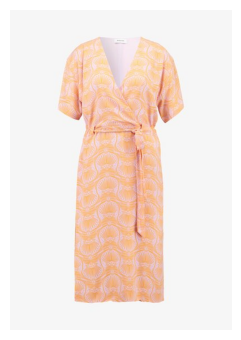

Product Item Id: 4707


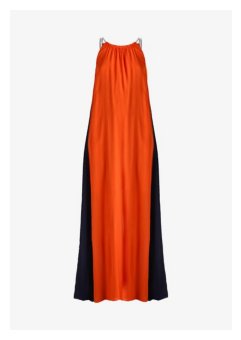

--- 0.42212963104248047 seconds to perform other auxiliary operations ---
--- 0.5301761627197266 seconds to perform the entire function ---


In [72]:
import time
start_time = time.time()
results = search_redis(client, 'orange sleeveless summer wear', k = 2)
print("--- %s seconds to perform the entire function ---" % (time.time() - start_time))